In [2]:
import numpy as np
import flopy
import flopy.utils.binaryfile as bf
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
import pyvista as pv
from scipy import stats
from scipy.interpolate import interp1d
from ipython2cwl.iotypes import *
from typing import List
import os

ModuleNotFoundError: No module named 'numpy'

In [2]:
exe_name_2005 = './binaries/mf2005'
exe_name_mt = './binaries/mt3dms'

In [3]:
#Parameters, inputs and outputs exposed
case: CWLIntInput = 2 # case number # 1-3 # 1:homogeneous aquifer, 2:midly heterogeneous aquifer, 3:highly heterogeneous aquifer
hydr: CWLStringInput = 2 # hydraulic gradient [-] # range 0-2 (float)
rech: CWLStringInput = 1 # recharge rate [L3/T] # range 0-1 (float)
inic: CWLStringInput = 1 # initial concentration of contaminant [M/L3] # range 0-1 (float)
degr: CWLStringInput = 0.5 # degradation rate [M/T] # range 0-1 (float)
conc: CWLIntInput = 30 # concerned time period [T] # range 0-30 (integer)
ground_water_flow_field_viz: CWLFilePathOutput = 'groundwaterflowfield.png'
break_through_curve_viz: CWLFilePathOutput = "break_through_curve.png"
arrival_time_viz: CWLFilePathOutput= "arrival_time.png"
contaminant_transport_list: List[CWLFilePathOutput] = ["contaminant_transport0.png", "contaminant_transport1.png", "contaminant_transport2.png"]

In [1]:
#Parameters, inputs and outputs not exposed
print(os.getcwd())
aquifer_file_case1: CWLFilePathInput = "aquifer1"
aquifer_file_case2: CWLFilePathInput = "aquifer2"
aquifer_file: CWLFilePathInput = 'aquifer.ftl'


NameError: name 'os' is not defined

In [5]:
def simulation(case, hydr, rech, inic, degr, conc):
    
    if True:
        # aquifer size
        delx = 1
        dely = 1
        delz = 1
        lambdax = 25
        lambday = 25
        lambdaz = 5
        nlay = lambdaz*3
        nrow = lambday*3
        ncol = lambdax*6
        ztop = 0.
        zbot = np.zeros((nlay, nrow, ncol))
        for i in range(nlay):
            zbot[i, :, :] = ztop - delz*(i+1)

        # flow boundary condition
        ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
        ibound[:, :, 0] = -1
        ibound[:, :, -1] = -1
        headend = hydr*ncol
        strt = np.ones((nlay, nrow, ncol), dtype=np.float32)
        strt[:, :, 0] = headend
        strt[:, :, -1] = 0
        lrcq = {}
        lrcq[0] = []
        for i in range(lambdax,lambdax*2):
            for j in range(lambday,lambday*2):
                lrcq[0].append([nlay-1, j, i, rech])

        # contamination source
        initial=np.zeros((nlay,nrow,ncol))
        for i in range(lambdax,lambdax*2):
            for j in range(lambday,lambday*2):
                initial[nlay-1, j, i] = inic

        # time domain            
        tlim=int(conc)
        times=np.linspace(0, tlim, num=tlim*10 + 1)

        # aquifer case
        if case == 1:
            hk = np.ones((nlay, nrow, ncol))
        elif case == 2:
            sgems=np.loadtxt(aquifer_file_case1, skiprows=1, delimiter=',')
            aquifer=np.zeros((nlay,nrow,ncol))
            aquifer=np.reshape(sgems.T,(nlay,nrow,ncol))
            hk = np.exp(aquifer)
        elif case == 3:
            sgems=np.loadtxt(aquifer_file_case2, skiprows=1, delimiter=',')
            aquifer=np.zeros((nlay,nrow,ncol))
            aquifer=np.reshape(sgems.T,(nlay,nrow,ncol))
            hk = np.exp(aquifer)        
        else:
            print('wrong case number')

        # MODFLOW2005
        modelname = 'aquifer'
        mf = flopy.modflow.Modflow(modelname, exe_name=exe_name_2005 )
        dis = flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol, delr=delx, delc=dely, top=ztop, botm=zbot, nper=1, perlen=tlim)
        bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
        lpf = flopy.modflow.ModflowLpf(mf, hk=hk)
        wel = flopy.modflow.ModflowWel(mf, stress_period_data=lrcq)
        oc = flopy.modflow.ModflowOc(mf)
        pcg = flopy.modflow.ModflowPcg(mf)
        lmt = flopy.modflow.ModflowLmt(mf, output_file_header='extended', output_file_format='formatted', output_file_name=modelname+".ftl")
        mf.write_input()
        success, buff = mf.run_model()

        if True:
            # MODFLOW2005 to MT3DMS
            f = open(aquifer_file, 'r')
            cell_number = nlay * nrow * ncol
            velocity_vector = np.zeros((cell_number,3))

            for line in f:
                if line[3] == 'X':
                    print(line)
                    subline = f.readline().split()
                    for j in range(3):
                        velocity_vector[j, 0] = float(subline[j])

                if line[3] == 'Y':
                    print(line)
                    subline = f.readline().split()
                    for j in range(3):
                        velocity_vector[j, 1] = float(subline[j])

                if line[3] == 'Z':
                    print(line)
                    subline = f.readline().split()
                    for j in range(3):
                        velocity_vector[j, 2] = float(subline[j])

            f.close()


            # MT3DMS
            mt = flopy.mt3d.Mt3dms(modflowmodel=mf, modelname=modelname, namefile_ext='mtnam',
                                   exe_name=exe_name_mt, ftlfree=True, ftlfilename=modelname+".ftl")
            btn=flopy.mt3d.Mt3dBtn(mt,prsity=0.4, sconc=initial, ncomp=1, nprs=1, timprs=times, savucn=True)
            adv = flopy.mt3d.Mt3dAdv(mt, mixelm=3, percel=0.75, mxpart=8000000)
            dsp = flopy.mt3d.Mt3dDsp(mt, al=0.01, trpt=0.1, trpv=0.01, dmcoef=1e-9)
            rct = flopy.mt3d.Mt3dRct(mt,isothm=0, igetsc=0)
            ssm = flopy.mt3d.Mt3dSsm(mt)
            gcg = flopy.mt3d.Mt3dGcg(mt)
            mt.write_input()
            success, buff=mt.run_model()    
    

In [6]:
# simulation with MODFLOW2005 & MT3DMS



simulation(case, hydr, rech, inic, degr, conc)

FloPy is using the following  executable to run the model: ./binaries/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: aquifer.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/10/01 19:32:13

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/10/01 19:32:16
 Elapsed run time:  3.500 Seconds

  Normal termination of simulation
 'QXX             '

 'QYY             '

 'QZZ             '

FloPy is using the following  executable to run the model: ./binaries/mt3dms
 MT3DMS - Modular 3-D Multi-Species Transport Model [Version 5.30]
 Developed at University of Alabama for U.S. Department of Defense

 Using NAME File: aquifer.mtnam                                     

 STRESS PERIOD NO.    1

 TIME STEP NO.    1
 FROM TIME

In [7]:
def resultvisulization(groundwaterflowfield, contaminantplumefield, breakthroughcurve, arrivaltimedistribution, inic, degr, conc):
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(600, 400))
    display.start()
    
    
    f = open('aquifer.ftl', 'r')
    delx = 1
    dely = 1
    delz = 1
    lambdax = 25
    lambday = 25
    lambdaz = 5
    nlay = lambdaz*3
    nrow = lambday*3
    ncol = lambdax*6
    cell_number = nlay * nrow * ncol
    velocity_vector = np.zeros((cell_number,3))
    for line in f:
        if line[3] == 'X':
            print(line)
            subline = f.readline().split()
            for j in range(3):
                velocity_vector[j, 0] = float(subline[j])

        if line[3] == 'Y':
            print(line)
            subline = f.readline().split()
            for j in range(3):
                velocity_vector[j, 1] = float(subline[j])

        if line[3] == 'Z':
            print(line)
            subline = f.readline().split()
            for j in range(3):
                velocity_vector[j, 2] = float(subline[j])
    f.close()
    factor = 27/np.quantile(velocity_vector, 0.99)
    vgrid = np.zeros((cell_number, 3))
    wellgrid = np.zeros((lambdax*lambday, 3))
    cpgrid = np.zeros((nlay*nrow, 3))
    iteration = 0
    deltal = 1
    for l in range(nlay):
        for k in range(nrow):
            for j in range(ncol):
                vgrid[iteration] = np.array(([j*deltal,k*deltal,l*deltal]))
                iteration += 1            
    iteration = 0        
    for l in range(lambdax, lambdax*2):
        for k in range(lambday, lambday*2):
            wellgrid[iteration] = np.array(([l*deltal,k*deltal,(nlay-1)*deltal]))
            iteration += 1
    iteration = 0        
    for l in range(lambday*3):
        for k in range(lambdaz*3):
            cpgrid[iteration] = np.array(([5*lambdax*deltal,l*deltal,k*deltal]))
            iteration += 1
    
    if groundwaterflowfield == True:
        rawgrid = vgrid.reshape((15,75,150,3))
        rawvelo = velocity_vector.reshape((15,75,150,3))
        avgrid = np.zeros((3,5,10,3))
        avvelo = np.zeros((3,5,10,3))
        for i in range(10):
            for j in range(5):
                for k in range(3):
                    avblock = rawgrid[5*k:(5*k+5),15*j:(15*j+15),15*i:(15*i+15)].reshape((15*15*5,3))
                    avgrid[k,j,i] = [np.mean([avblock[i][0] for i in range(15*15*5)]),
                                     np.mean([avblock[i][1] for i in range(15*15*5)]),
                                     np.mean([avblock[i][2] for i in range(15*15*5)])]
                    avblock = rawvelo[5*k:(5*k+5),15*j:(15*j+15),15*i:(15*i+15)].reshape((15*15*5,3))
                    avvelo[k,j,i] = [np.mean([avblock[i][0] for i in range(15*15*5)]),
                                     np.mean([avblock[i][1] for i in range(15*15*5)]),
                                     np.mean([avblock[i][2] for i in range(15*15*5)])]
        avgrid = avgrid.reshape((10*5*3, 3))
        avvelo = avvelo.reshape((10*5*3, 3))        

        point_cloud = pv.PolyData(avgrid)
        point_cloud['vectors'] = avvelo
        arrows = point_cloud.glyph(orient='vectors', scale=True, factor=factor)
        plotter = pv.Plotter(notebook=True, window_size=(600,400))
        plotter.add_text('Groundwater flow vectors',position='upper_edge', font='arial', font_size=10, color='k')
        sargs = dict(
            title_font_size=1,
            label_font_size=1,
            n_labels=5,
            fmt="%.1f",
            color ='k',
            font_family="arial")
        plotter.add_mesh(arrows, scalars='GlyphScale', lighting=True, show_scalar_bar=True, 
                         stitle='Groundwater flow [L3/T]' , scalar_bar_args=sargs, opacity=0.8)
        plotter.enable_eye_dome_lighting()
        plotter.set_background('w')
        welldata = pv.PolyData(wellgrid)
        outline = welldata.outline()
        plotter.add_mesh(outline, color="blue", line_width=6, label='recharge zone')
        cpdata = pv.PolyData(cpgrid)
        outline2 = cpdata.outline()
        plotter.add_mesh(outline2, color="green", line_width=6, label='control plane')
        plotter.show_bounds(bounds=[0, 150, 0, 75, 0, 15], grid='back', location='outer', xlabel = 'x [L]', ylabel = 'y [L]', 
                            zlabel = 'z [L]', italic=True, font_family="arial", font_size=12)
        plotter.add_legend(bcolor=[255,255,255], border=True, size=[0.15,0.06])
        plotter.show()
        plotter.screenshot(filename=ground_water_flow_field_viz, transparent_background=True)
 
    if contaminantplumefield == True:
        c=bf.UcnFile('MT3D001.UCN')
        cpoint_cloud = pv.PolyData(vgrid)
        ctimes = c.get_times()
        screenshots = [ctimes[0], ctimes[int(len(ctimes)/2)], ctimes[-1]]

        for i in range(3):
            cfield = c.get_data(totim=screenshots[i]).flatten()
            cpoint_cloud = pv.PolyData(vgrid)
            plotter = pv.Plotter(notebook=True, window_size=(600,400))
            plotter.add_text('Contaminant plume at t = '+str(screenshots[i])+' [T]',position='upper_edge', font='arial', font_size=10, color='k')
            sargs = dict(
                title_font_size=1,
                label_font_size=1,
                n_labels=5,
                fmt="%.3f",
                color ='k',
                font_family="arial")
            welldata = pv.PolyData(wellgrid)
            outline = welldata.outline()
            plotter.add_mesh(outline, color="blue", line_width=6, label='recharge zone')
            cpdata = pv.PolyData(cpgrid)
            outline2 = cpdata.outline()
            plotter.add_mesh(outline2, color="green", line_width=6, label='control plane')
            plotter.add_mesh(cpoint_cloud, scalars=cfield, show_scalar_bar=True, lighting=True, point_size=7, 
                             render_points_as_spheres=True, opacity='linear',
                             stitle='Contaminant concentration [M/L3]' , scalar_bar_args=sargs, cmap='bone_r' )
            plotter.show_bounds(bounds=[0, 150, 0, 75, 0, 15], grid='back', location='outer', xlabel = 'x [L]', ylabel = 'y [L]', 
                                zlabel = 'z [L]', italic=True, font_family="arial", font_size=12)
            plotter.enable_eye_dome_lighting()
            plotter.set_background('w')
            plotter.add_legend(bcolor=[255,255,255], border=True, size=[0.15,0.06])
            plotter.show()
            plotter.screenshot(filename=contaminant_transport_list[i], transparent_background=True)
            
            
    if breakthroughcurve == True:
        c=bf.UcnFile('MT3D001.UCN')
        ctimes = c.get_times()

        for k in range(len(ctimes)):
            concentration=c.get_data(totim=ctimes[k])
            if np.sum(concentration[:,:,lambdax*5]) >= 0.001:
                initime = ctimes[k]
                initk = k
                break

        concen = np.zeros(len(ctimes))
        init = np.sum(c.get_data(totim=initime)[:,:,:lambdax*5])
        cpc = 0

        for k in range(initk,len(ctimes)):
            concentration=c.get_data(totim=ctimes[k])
            cpc = (init - np.sum(concentration[:,:,:lambdax*5]))/init
            concen[k] = cpc

        fig, ax = plt.subplots(figsize=(5,4))
        ax.title.set_text('Breakthrough curve at control plane')
        ax.plot(ctimes, concen, color='k', linewidth=5)
        plt.xlabel(r'$t$ [T]', size=16)
        plt.ylabel(r'$M/M_0$', size=16)
        plt.xticks(size=14)
        plt.yticks(size=14)
        plt.xticks(fontsize=14, fontname='Arial')
        plt.yticks(fontsize=14, fontname='Arial')
        ax.xaxis.set_major_locator(MultipleLocator(int(conc/5)))
        ax.xaxis.set_minor_locator(MultipleLocator(int(conc/25)))
        ax.yaxis.set_major_locator(MultipleLocator(0.2))
        ax.yaxis.set_minor_locator(MultipleLocator(0.04))
        plt.yticks(fontsize=14, fontname='Arial')
        ax.tick_params(which="major", direction="in", right=True, top=True, length=5)
        ax.tick_params(which="minor", direction="in", right=True, top=True, length=3)
        plt.ylim(0,1)
        plt.xlim(0,conc)
        plt.tight_layout()
        plt.savefig('breakthroughcurve.png',dpi=400)
        plt.show()

    if arrivaltimedistribution == True:
        c=bf.UcnFile('MT3D001.UCN')
        ctimes = c.get_times()
        
        for k in range(len(ctimes)):
            concentration=c.get_data(totim=ctimes[k])
            if np.sum(concentration[:,:,lambdax*5]) >= 0.001:
                initime = ctimes[k]
                initk = k
                break

        concen = np.zeros(len(ctimes))
        init = np.sum(c.get_data(totim=initime)[:,:,:lambdax*5])
        cpc = 0

        for k in range(initk,len(ctimes)):
            concentration=c.get_data(totim=ctimes[k])
            cpc = (init - np.sum(concentration[:,:,:lambdax*5]))/init
            concen[k] = cpc        
        
        intpx = []
        intpy = []

        for i in range(len(ctimes)):
            if concen[i] >= 0.01:
                if concen[i] >= 0.99:
                    break
                intpx.append(concen[i])
                intpy.append(ctimes[i])
        intpx = np.asarray(intpx)
        intpy = np.asarray(intpy)

        f1 = interp1d(intpx, intpy, kind='quadratic')
        newconc = np.linspace(intpx.min(), intpx.max(), num=51)
        newtime = f1(newconc)

        fig, ax = plt.subplots(figsize=(5,4))
        ax.title.set_text('Arrival time distribution at control plane')
        histdata = ax.hist(newtime, 20, color='k', density=True)
        ax.vlines(inic/degr,0,np.max(histdata[0]), color='red', label='time for 100% decay')
        ax.hist(newtime, 20, color='k', density=True)
        plt.xlabel(r'$t_{arrival}$ [T]', size=16)
        plt.ylabel(r'Probability density', size=16)
        plt.xticks(size=14)
        plt.yticks(size=14)
        plt.legend(fontsize=12)
        plt.tight_layout()
        plt.savefig('arrivaltime.png',dpi=400)
        plt.show()


 'QXX             '

 'QYY             '

 'QZZ             '



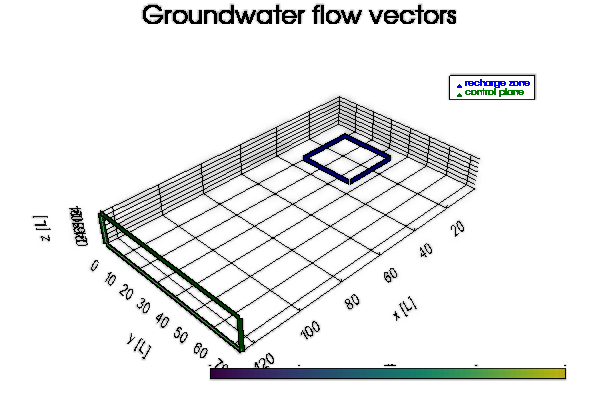

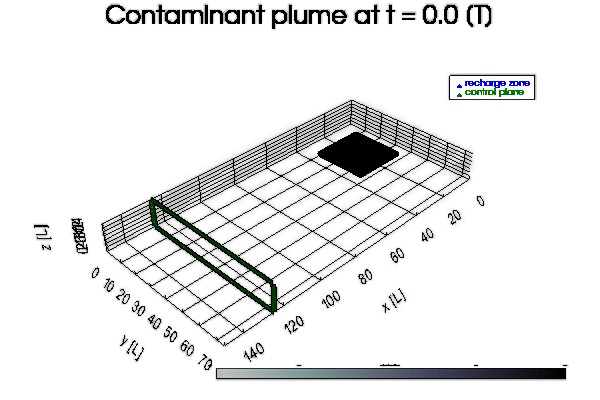

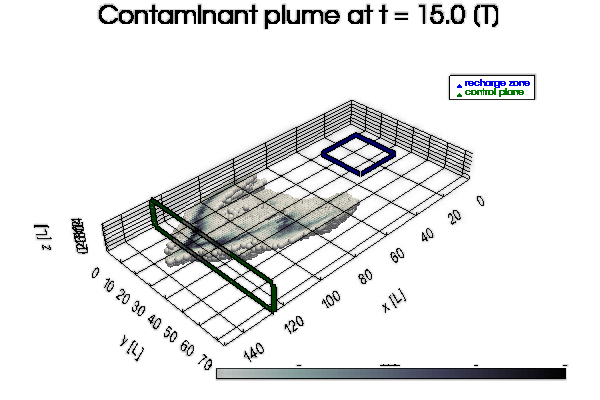

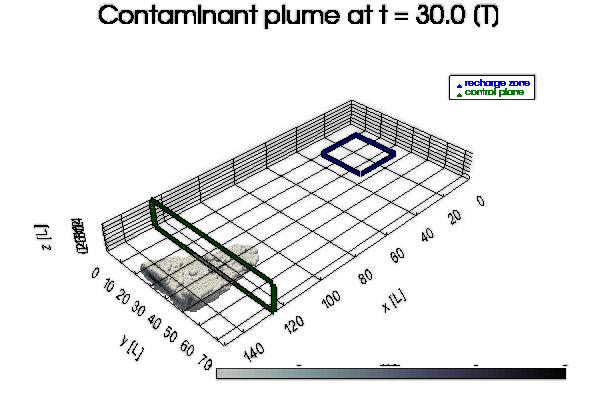

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


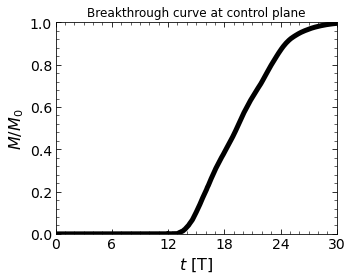

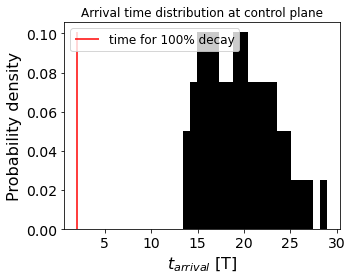

In [8]:
# output

groundwaterflowfield = True
contaminantplumefield = True
breakthroughcurve = True
arrivaltimedistribution = True

resultvisulization(groundwaterflowfield, contaminantplumefield, breakthroughcurve, arrivaltimedistribution, inic, degr, conc)